In [2]:
!pip install segmentation_models_3D
#!pip install keras
#!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 80.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 92.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing install

In [3]:
import glob
import os
from tqdm import tqdm
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [4]:
# 3D Unet Model

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

In [5]:
# Custom Data Loader
def load_img(img_dir, img_list, orient, test=True):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)
            images.append(image)
            
            if test:
                image_aug = np.stack([tf.image.rot90(image[:,:,:,i], k=orient) for i in range(4)], axis=3)
                images.append(image_aug)
    images = np.array(images)

    return(images)



def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size, debug=False, test=True):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            
            if debug==True:
                print('Batch :: ',batch_start//batch_size)
            
            limit = min(batch_end, L)
            orient = np.random.randint(1, 3)

            X = load_img(img_dir, img_list[batch_start:limit], orient, test=test)
            Y = load_img(mask_dir, mask_list[batch_start:limit], orient, test=test)

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [6]:
Train_dir = '/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Train/'
Label_dir = '/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Label/'

In [7]:
from sklearn.model_selection import train_test_split
USE = [i for i in range(1,485)]
seed = 40

X_Main, X_Test, Y_Main, Y_Test = train_test_split(USE, USE, test_size=0.2, random_state=seed)
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Main, Y_Main, test_size=0.2, random_state=seed)

with open('Train_List.txt','w') as f:
    f.write(str(X_Train))
f.close()

with open('Val_List.txt','w') as g:
    g.write(str(X_Val))
g.close()

with open('Test_List.txt','w') as h:
    h.write(str(X_Test))
h.close()

In [8]:
Train_list_tr = [str(i)+'.npy' for i in X_Train]
Label_list_tr = [str(i)+'.npy' for i in Y_Train]
batch_size = 2

Train_dgen = imageLoader(Train_dir, Train_list_tr, Label_dir, Label_list_tr, batch_size, debug=False, test=True)
steps_per_epoch = len(Train_list_tr)//batch_size

In [9]:
Train_list_val = [str(i)+'.npy' for i in X_Val]
Label_list_val = [str(i)+'.npy' for i in Y_Val]
batch_size = 2

Val_dgen = imageLoader(Train_dir, Train_list_val, Label_dir, Label_list_val, batch_size, debug=True, test=False)

In [10]:
LR = 0.0001
import tensorflow as tf
optim = tf.keras.optimizers.Adam(LR)

wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

Segmentation Models: using `tf.keras` framework.


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/brats_3d_aug_120_epoch.hdf5',
    save_best_only=True,
    monitor='loss',      # You can use other metrics like 'val_accuracy'
    mode='min',          # 'min' if monitoring loss, 'max' if monitoring accuracy
    verbose=1
)

In [12]:
model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=4,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 16)    1744      ['input_2[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 128, 128, 128, 16)    0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 16)    6928      ['dropout_2[0][0]']           
                                                                                            

In [13]:
model.load_weights('/kaggle/input/brats-aug-weights/brats_3d_aug_80_epoch.hdf5')

In [14]:
history=model.fit(Train_dgen,
                  steps_per_epoch=steps_per_epoch,
                  epochs=40,
                  callbacks=[checkpoint_callback],
                  validation_data=Val_dgen,
                  validation_steps=len(Train_list_val)//batch_size,
                  verbose=1)

Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1709219083.555521      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 [==============================] - ETA: 0s - loss: 0.7964 - accuracy: 0.9868 - iou_score: 0.7362Batch ::  0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Batch ::  1
Batch ::  2
Batch ::  3
Batch ::  4
Batch ::  5
Batch ::  6
Batch ::  7
Batch ::  8
Batch ::  9
Batch ::  10
Batch ::  11
Batch ::  12
Batch ::  13
Batch ::  14
Batch ::  15
Batch ::  16
Batch ::  17
Batch ::  18
Batch ::  19
Batch ::  20
Batch ::  21
Batch ::  22
Batch ::  23
Batch ::  24
Batch ::  25
Batch ::  26
Batch ::  27
Batch ::  28
Batch ::  29
Batch ::  30
Batch ::  31
Batch ::  32
Batch ::  33
Batch ::  34
Batch ::  35
Batch ::  36
Batch ::  37
Batch ::  38
Batch ::  0

Epoch 1: loss improved from inf to 0.79637,

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  


154/154 [==============================] - 570s 3s/step - loss: 0.7964 - accuracy: 0.9868 - iou_score: 0.7362 - val_loss: 0.8105 - val_accuracy: 0.9811 - val_iou_score: 0.6791
Epoch 2/40
154/154 [==============================] - ETA: 0s - loss: 0.7955 - accuracy: 0.9871 - iou_score: 0.7404Batch ::  1
Batch ::  2
Batch ::  3
Batch ::  4
Batch ::  5
Batch ::  6
Batch ::  7
Batch ::  8
Batch ::  9
Batch ::  10
Batch ::  11
Batch ::  12
Batch ::  13
Batch ::  14
Batch ::  15
Batch ::  16
Batch ::  17
Batch ::  18
Batch ::  19
Batch ::  20
Batch ::  21
Batch ::  22
Batch ::  23
Batch ::  24
Batch ::  25
Batch ::  26
Batch ::  27
Batch ::  28
Batch ::  29
Batch ::  30
Batch ::  31
Batch ::  32
Batch ::  33
Batch ::  34
Batch ::  35
Batch ::  36
Batch ::  37
Batch ::  38
Batch ::  0
Batch ::  1

Epoch 2: loss improved from 0.79637 to 0.79547, saving model to /kaggle/working/brats_3d_aug_120_epoch.hdf5
154/154 [==============================] - 552s 4s/step - loss: 0.7955 - accuracy: 0.9871 -

In [15]:
model.save('model_120_aug_epochs.h5')

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'iou_score', 'val_loss', 'val_accuracy', 'val_iou_score'])

In [17]:
with open('Epoch_aug_120_score.txt','w') as h:
    h.write(str(history.history))
h.close()

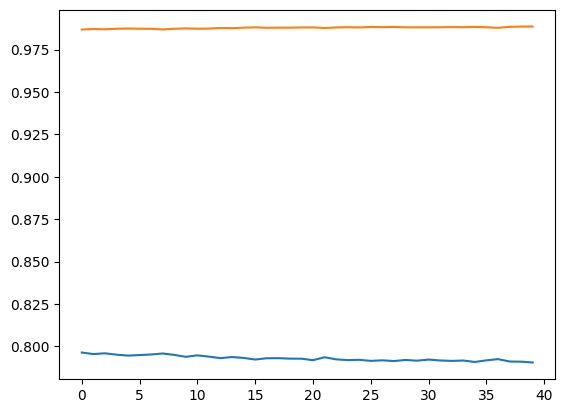

In [18]:
X = history.history['loss']
Y = history.history['accuracy']
plt.plot(X)
plt.plot(Y)

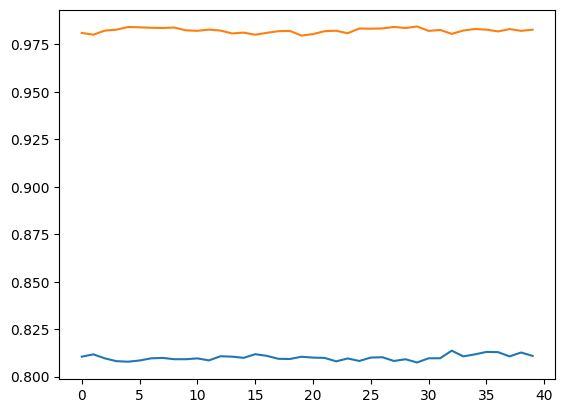

In [19]:
X = history.history['val_loss']
Y = history.history['val_accuracy']
plt.plot(X)
plt.plot(Y)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 1s/step


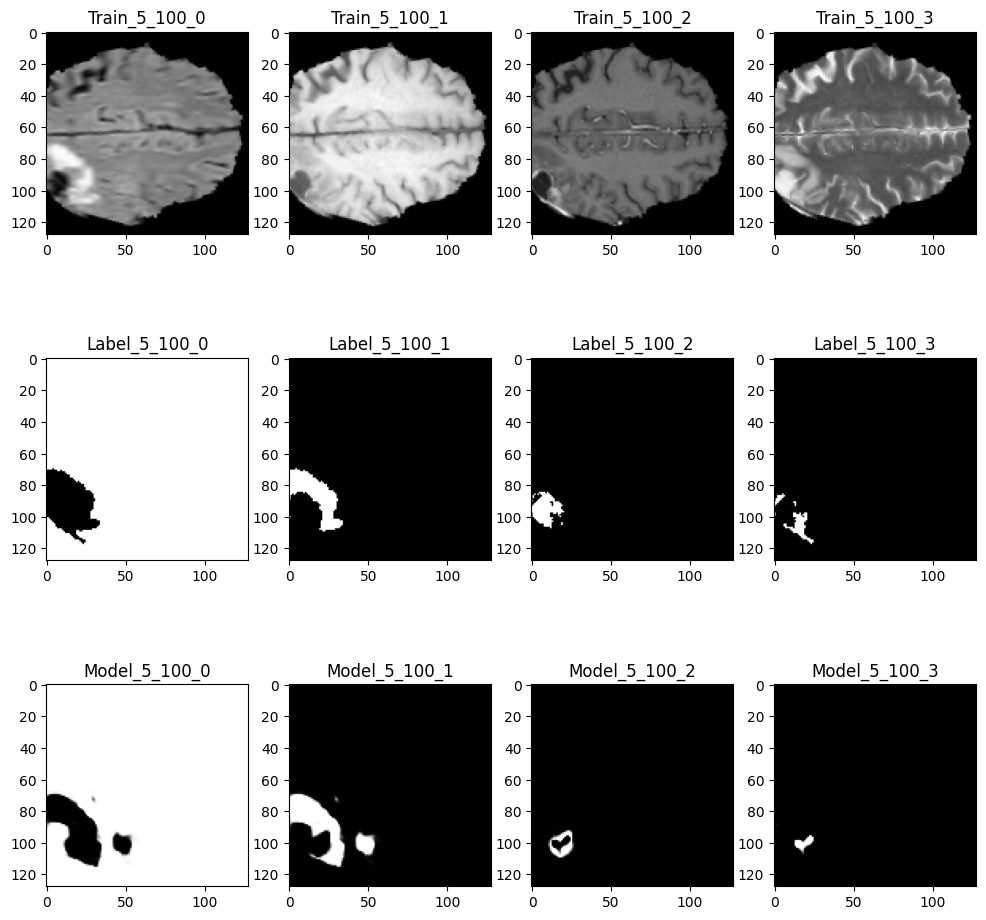

In [20]:
num = str(5)
slide = 100
t_img_1 = np.load('/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Train/'+ num +'.npy')
l_img_1 = np.load('/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Label/'+ num +'.npy')
g_1 = load_img('/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Train/',[num + '.npy'],orient=0)
f_1 = model.predict(g_1)

m = 4
fig = plt.figure(figsize=(3*m,3*m))
for i in range(3):
    if i == 0:
        use = t_img_1[:,:,slide,:]
        n = 'Train'
    elif i == 1:
        use = l_img_1[:,:,slide,:]
        n = 'Label'
    else:
        use = f_1[0,:,:,slide,:]
        n = 'Model'
    
    
    for j in range(4):
        fig.add_subplot(3,4,(i*4)+j+1)
        plt.imshow(use[:,:,j],cmap='gray')
        plt.title(n+'_'+num+'_'+str(slide)+'_'+str(j))
        

In [21]:
Train_list_test = [str(i)+'.npy' for i in X_Test]
Label_list_test = [str(i)+'.npy' for i in Y_Test]
batch_size = 2

Test_dgen = imageLoader(Train_dir, Train_list_test, Label_dir, Label_list_test, batch_size, test=False)#, debug=True

In [22]:
history2 = model.evaluate(Test_dgen,
                         batch_size=batch_size,
                         steps=len(Train_list_test)//batch_size)

48/48 [==============================] - 100s 2s/step - loss: 0.8156 - accuracy: 0.9839 - iou_score: 0.6543


In [ ]:
history2

1/1 [==============================] - 0s 98ms/step


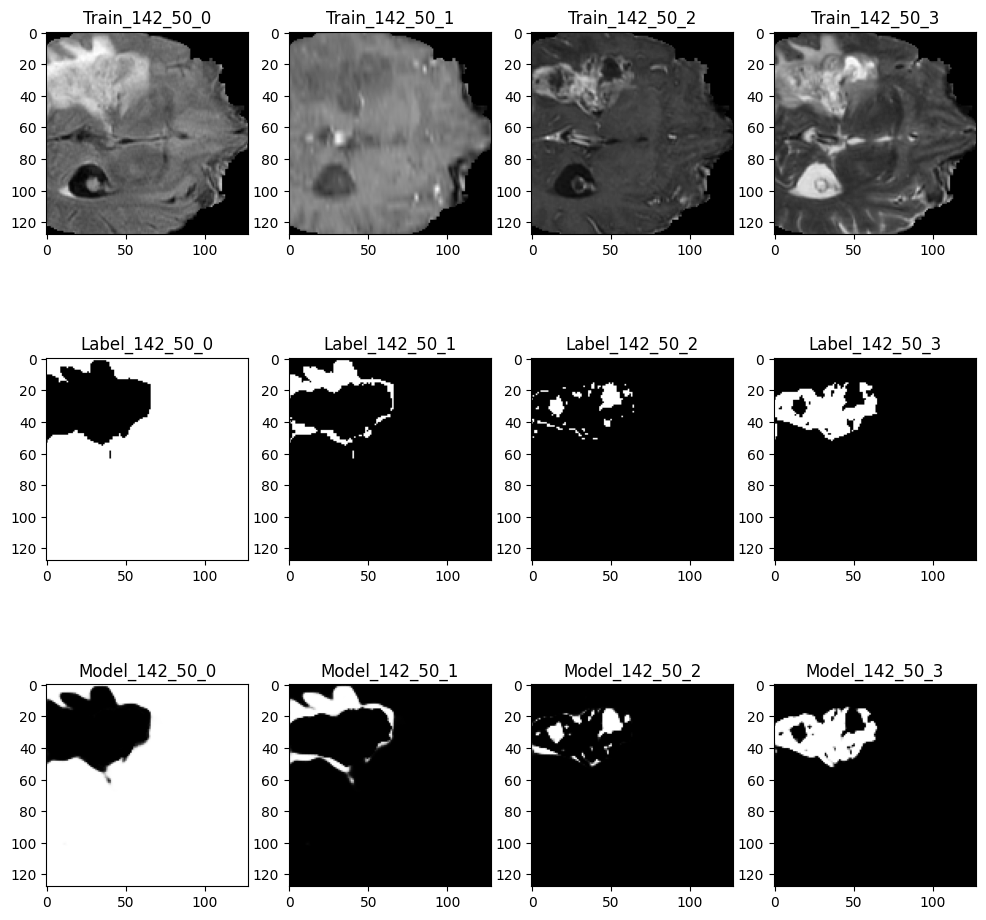

In [23]:
import random as rnd
num = str(rnd.choice(X_Test))
slide = 50
t_img_1 = np.load('/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Train/'+ num +'.npy')
l_img_1 = np.load('/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Label/'+ num +'.npy')
g_1 = load_img('/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Train/',[num + '.npy'],orient=0)
f_1 = model.predict(g_1)

m = 4
fig = plt.figure(figsize=(3*m,3*m))
for i in range(3):
    if i == 0:
        use = t_img_1[:,:,slide,:]
        n = 'Train'
    elif i == 1:
        use = l_img_1[:,:,slide,:]
        n = 'Label'
    else:
        use = f_1[0,:,:,slide,:]
        n = 'Model'
    
    
    for j in range(4):
        fig.add_subplot(3,4,(i*4)+j+1)
        plt.imshow(use[:,:,j],cmap='gray')
        plt.title(n+'_'+num+'_'+str(slide)+'_'+str(j))
        

In [24]:
!mkdir CMP_Test

In [25]:
import gc
gc.collect()

39192

100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


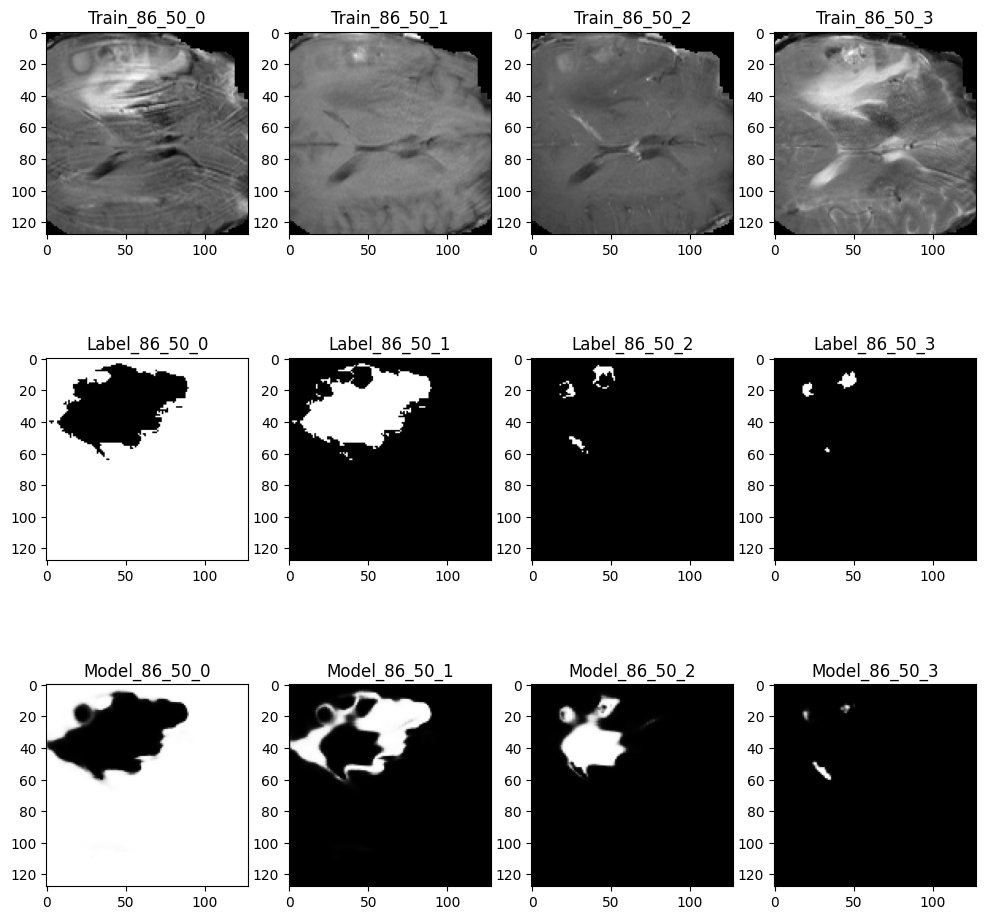

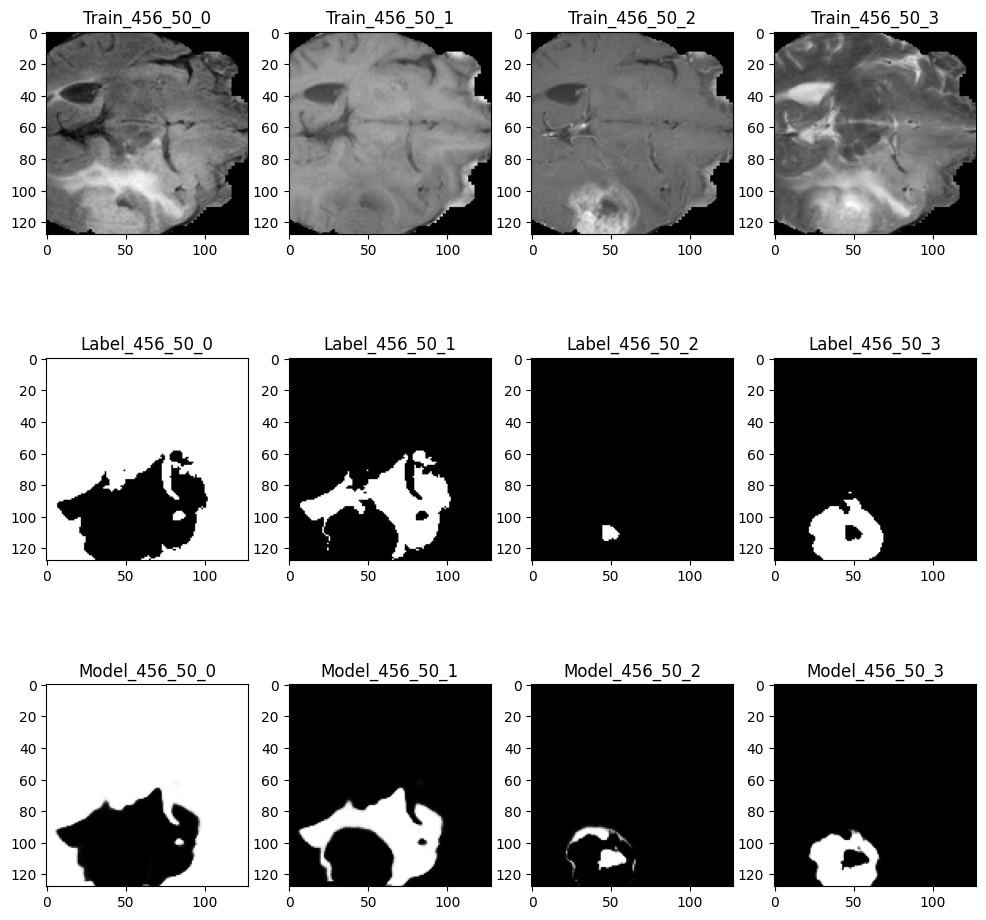

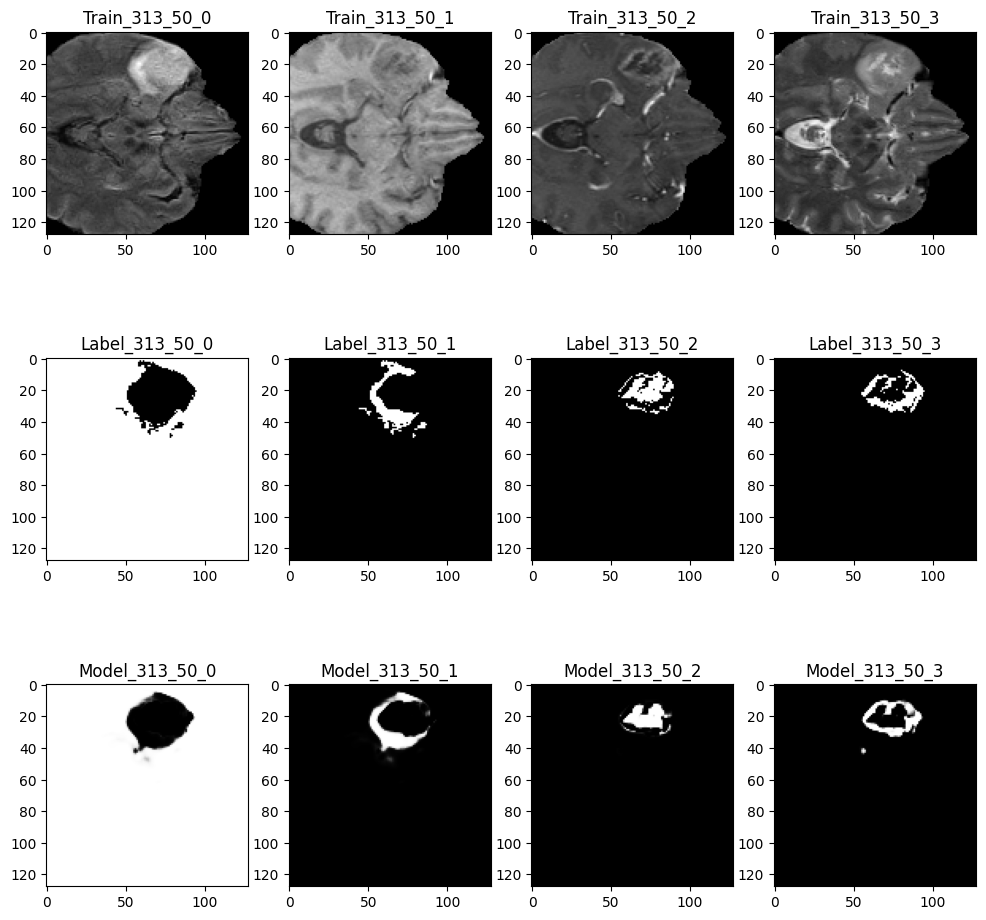

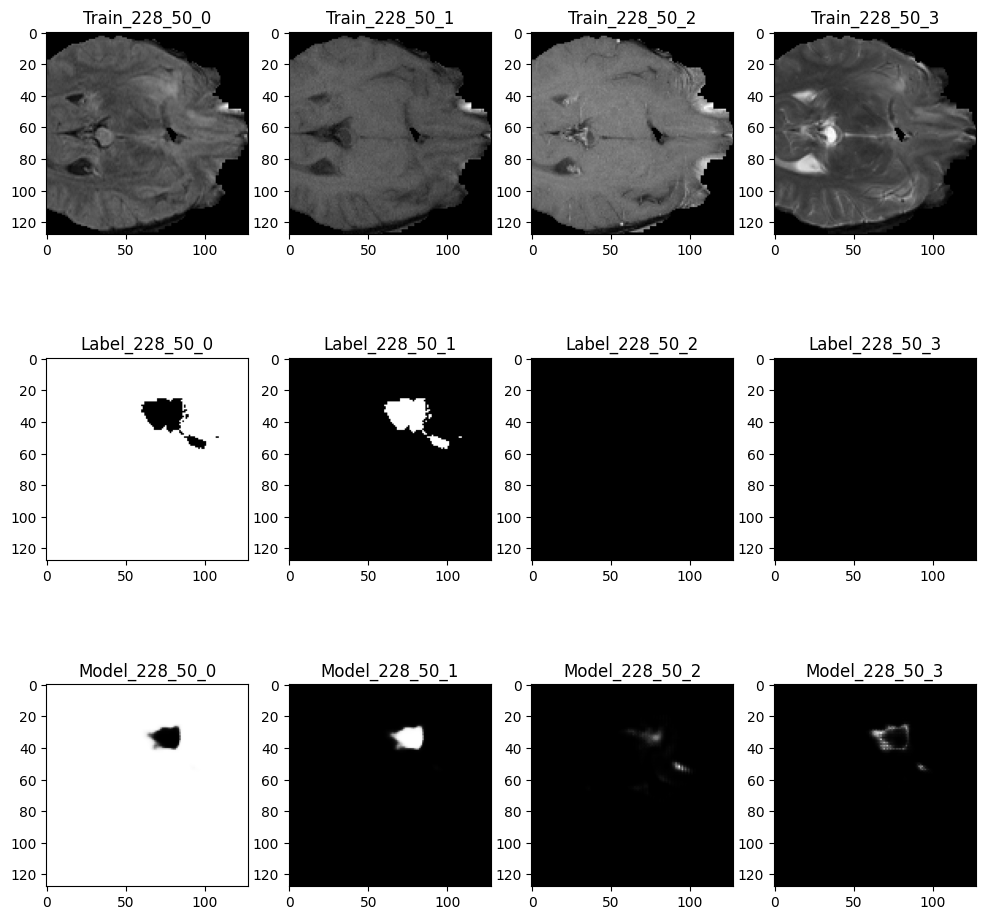

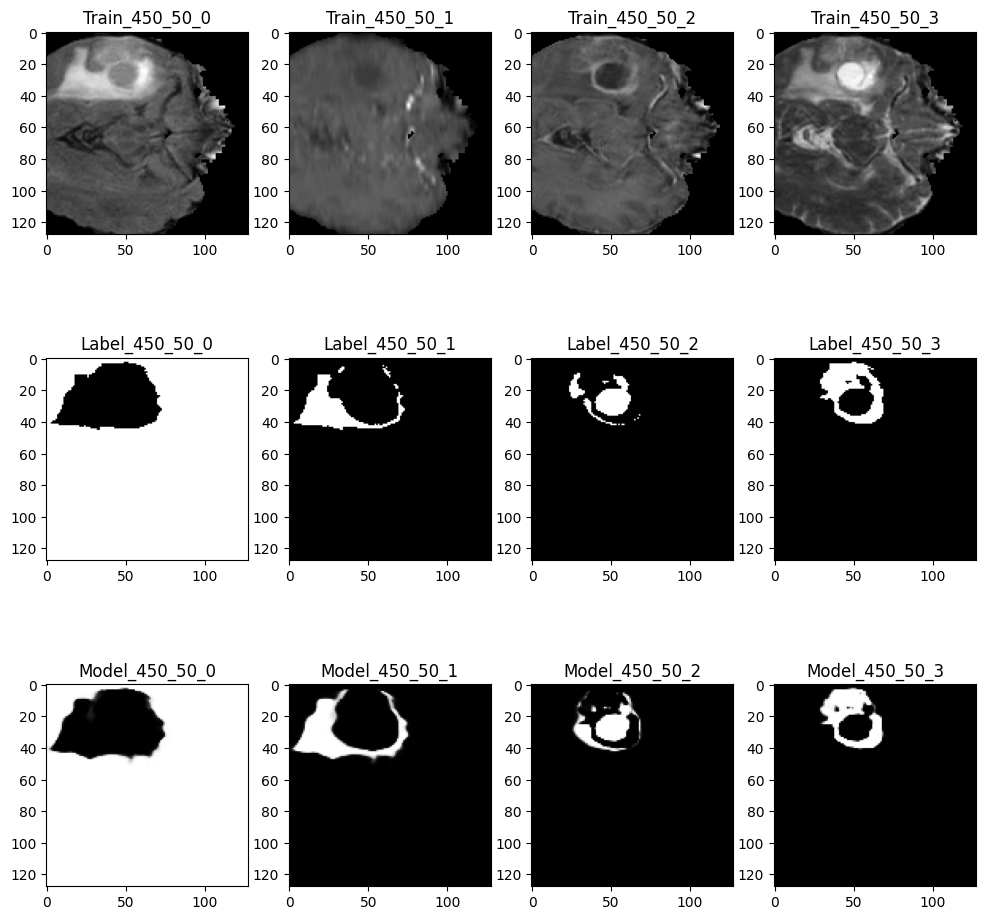

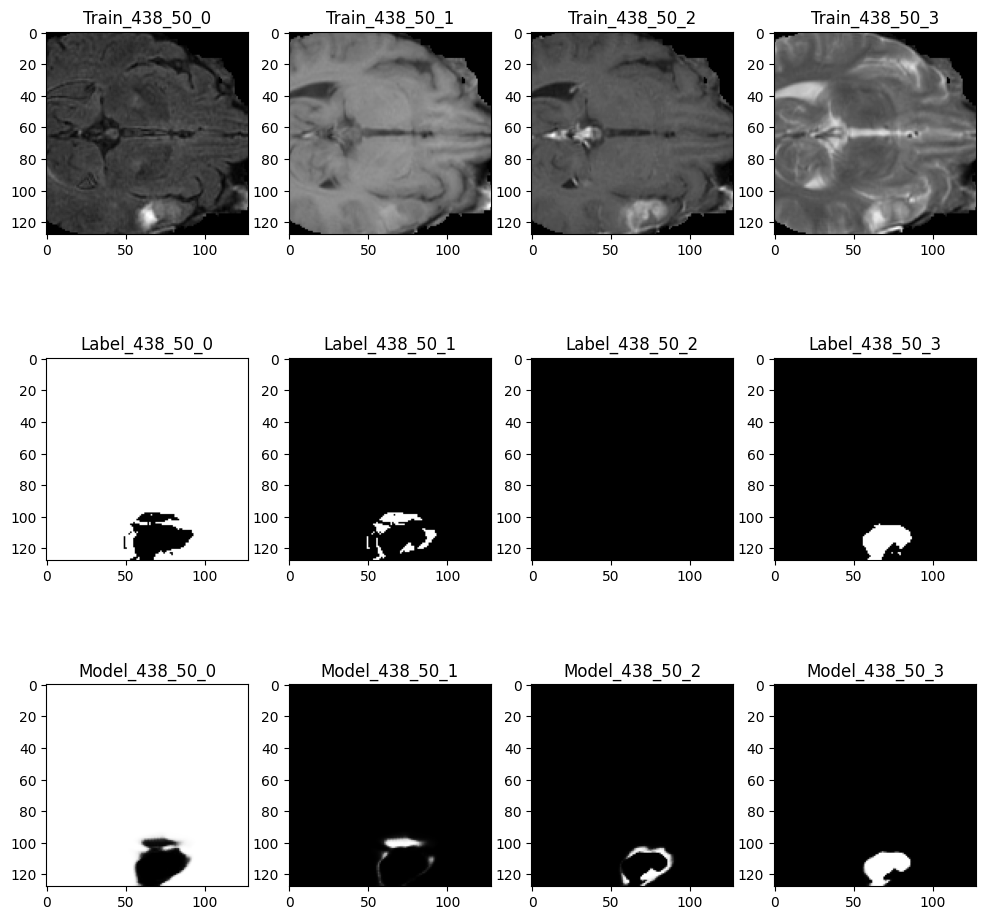

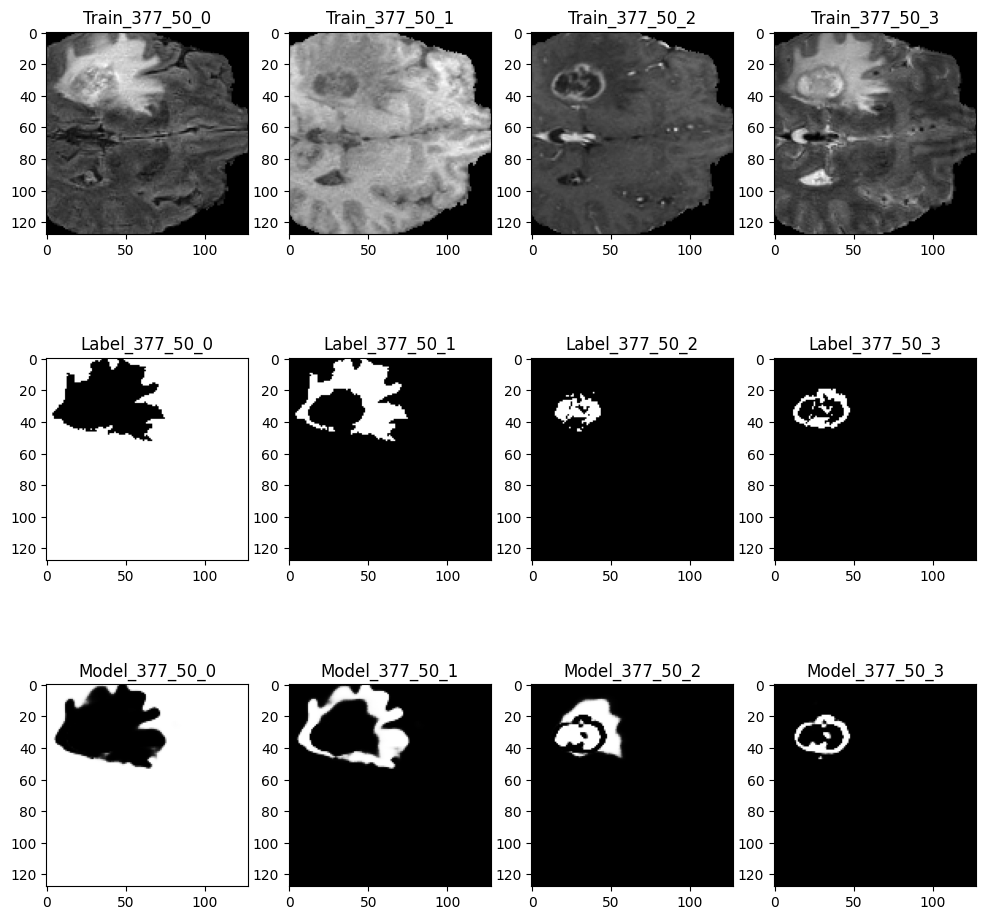

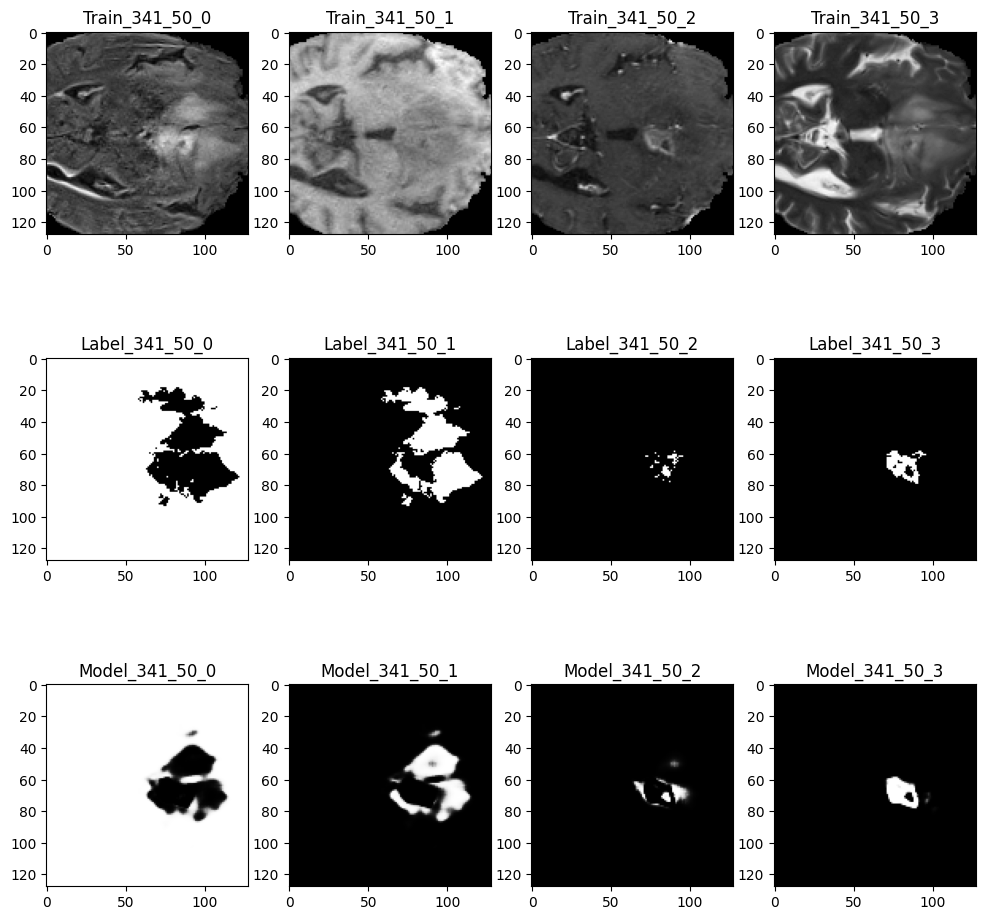

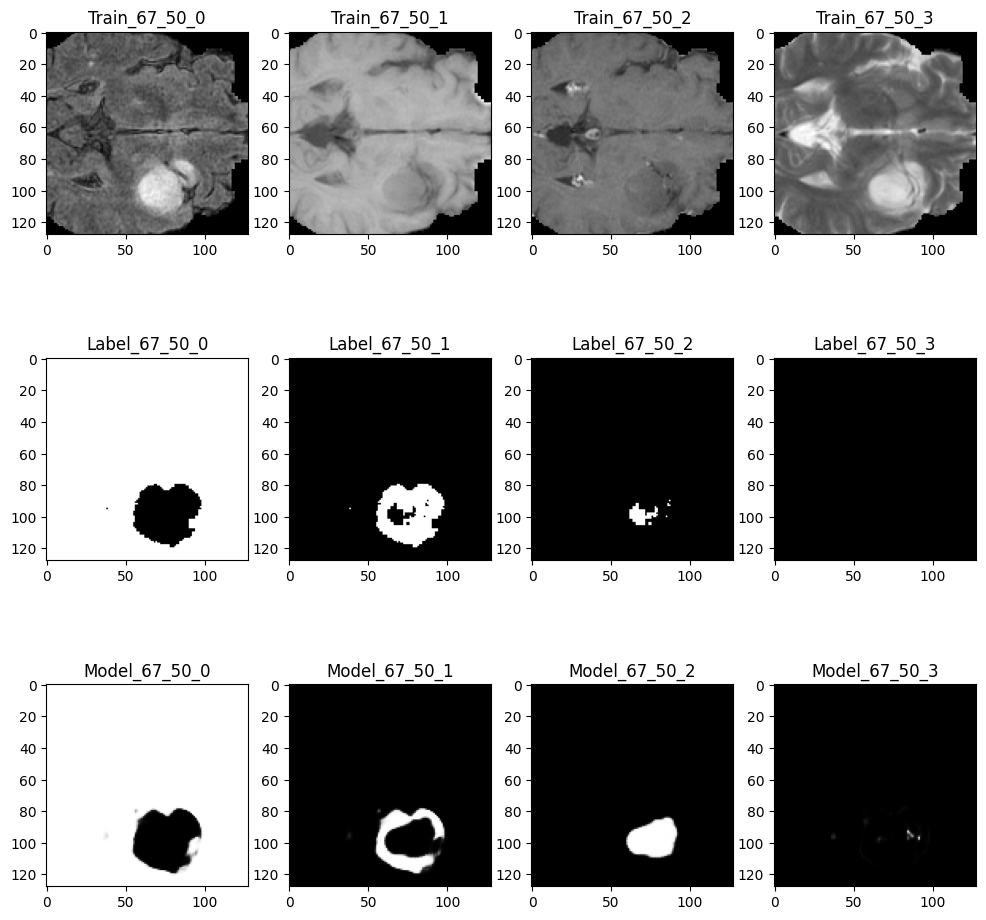

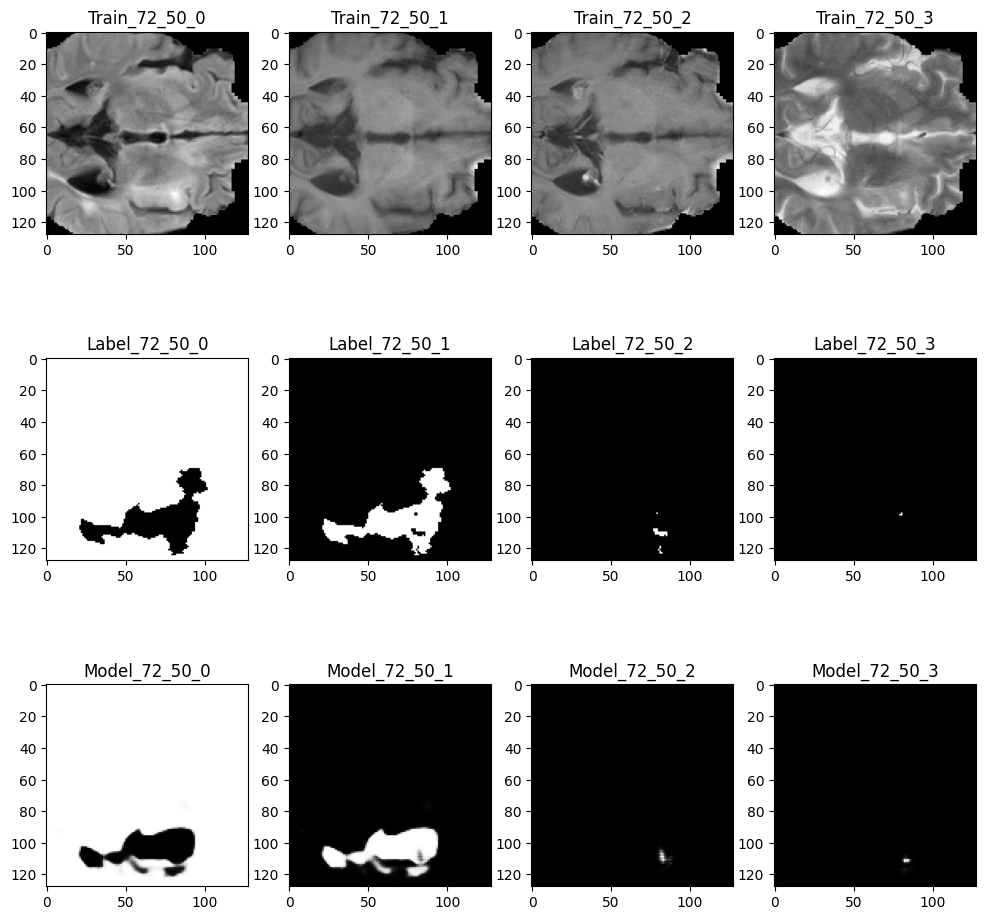

In [26]:
another = [ele for ele in X_Test]
for k in tqdm(range(1,11)):
    num = str(rnd.choice(another))
    another.remove(int(num))
    slide = 50
    t_img_1 = np.load('/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Train/'+ num +'.npy')
    l_img_1 = np.load('/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Label/'+ num +'.npy')
    g_1 = load_img('/kaggle/input/brain-data-prep-01/Brain_Data_Prep_01/Train/',[num + '.npy'],orient=0)
    f_1 = model.predict(g_1,verbose=0)

    m = 4
    fig = plt.figure(figsize=(3*m,3*m))
    for i in range(3):
        if i == 0:
            use = t_img_1[:,:,slide,:]
            n = 'Train'
        elif i == 1:
            use = l_img_1[:,:,slide,:]
            n = 'Label'
        else:
            use = f_1[0,:,:,slide,:]
            n = 'Model'


        for j in range(4):
            fig.add_subplot(3,4,(i*4)+j+1)
            plt.imshow(use[:,:,j],cmap='gray')
            plt.title(n+'_'+num+'_'+str(slide)+'_'+str(j))
    plt.savefig('/kaggle/working/CMP_Test/'+str(k)+'_sample.png')

In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

u = unet()

2024-02-29 15:02:47.185634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 15:02:47.185759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 15:02:47.312413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
